# Ride Duration Prediction (For-Hire Vehicle Trip Records)

The goal of this homework is to train a simple model for predicting the duration of a ride

## Data

We'll use [For-Hire Vehicle Trip Records](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) "Yellow Taxi Trip Records". dataset

Download the data for January and February 2022.

## Q1. January 2022: How many columns are there?

In [69]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [70]:
def read_dataframe(filename):
    return pd.read_parquet(filename)

In [71]:
df_january = read_dataframe('./data/yellow_tripdata_2022-01.parquet')

In [72]:
len(df_january.columns)

19

The solution is **19**

## Q2. Computing duration

What's the standard deviation of the trips duration in January?

In [73]:
df_january.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [74]:
def compute_duration(df):
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    return df

In [75]:
df_january = compute_duration(df_january)

In [76]:
average_trip_duration = df_january['duration'].std()
round(average_trip_duration, 2)

46.45

The solution is **46.45**

## Q3. Dropping outliers

**What fraction of the records left after you dropped the outliers?**

Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

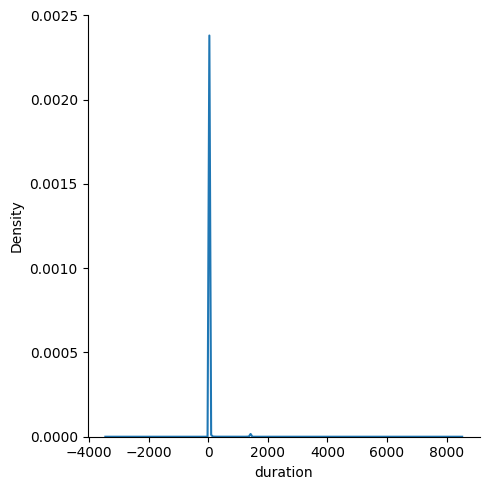

In [77]:
sns.displot(df_january, x="duration",  kind="kde")

In [78]:
def remove_duration_outliers(df):
    new_df = df.copy()
    new_df = new_df[(new_df.duration >= 1) & (new_df.duration <= 60)]
    return new_df

In [79]:
df_january_duration = remove_duration_outliers(df_january)

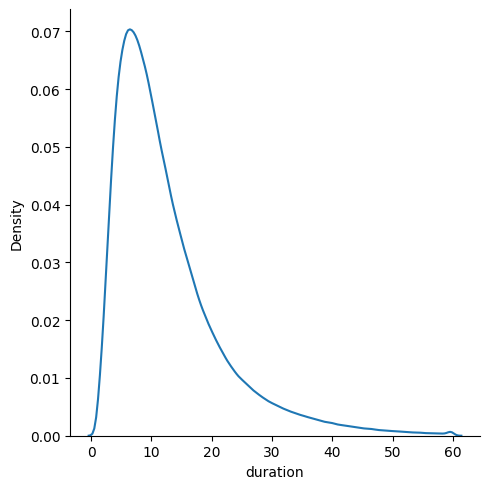

In [80]:
sns.displot(df_january_duration, x="duration",  kind="kde")

In [81]:
# What fraction of the records left after you dropped the outliers?
len(df_january_duration) / len(df_january) * 100

98.27547930522405

We kept **98%** records

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer
* Get a feature matrix from it

**What's the dimensionality of this matrix (number of columns)?**

In [82]:
categorical = ['PULocationID', 'DOLocationID']

Fill null values in the categorical features

In [83]:
def fillna_categorical(df):
    df[categorical] = df[categorical].fillna(-1).astype('int')
    df[categorical] = df[categorical].astype('str')
    return df
df_january_duration = fillna_categorical(df_january_duration)

In [84]:
def one_hot_encoding(df, dv=None):
    if dv is None:
        dv = DictVectorizer()
        X = dv.fit_transform(df[categorical].to_dict(orient='records'))
    else:
        X = dv.transform(df[categorical].to_dict(orient='records'))
    return X, dv
X_train, dv = one_hot_encoding(df_january_duration)

In [85]:
X_train.shape

(2421440, 515)

The dimensionality of the matrix (columns) is **515**

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

* Train a plain linear regression model with default parameters

* Calculate the RMSE of the model on the training data

**What's the RMSE on train?**

In [86]:
target = 'duration'
y_train = df_january_duration[target].values

In [87]:
def validate_lr(lr, X, y):
    y_pred = lr.predict(X)
    mse = mean_squared_error(y, y_pred, squared=False)
    
    return mse, y_pred

def train_lr(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    mse, _ = validate_lr(lr, X, y)
    print(mse)
    
    return lr

In [88]:
lr = train_lr(X_train, y_train)

6.986190814952337


The RMSE on the training data is **6.99**

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2022).

**What's the RMSE on validation?**

In [96]:
# Create generic load and preprocess function
def load_preprocess_dataframe(filename, target='duration', dv=None):
    df = read_dataframe(filename)
    df = compute_duration(df)
    df = remove_duration_outliers(df)
    df = fillna_categorical(df)
    X, dv = one_hot_encoding(df, dv)
    y = df[target].values
    
    return X, y

In [97]:
# Load validation data
X_val, y_val = load_preprocess_dataframe('./data/yellow_tripdata_2022-02.parquet', target='duration', dv=dv)
X_val.shape

(2918187, 515)

In [98]:
mse, y_pred = validate_lr(lr, X_val, y_val)
print(mse)

7.786407163179794


The RMSE on the training data is **7.79**

/var/folders/q8/6pzc9r955kd8whj1ss97qt080000gn/T/ipykernel_84163/2624495092.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/q8/6pzc9r955kd8whj1ss97qt080000gn/T/ipykernel_84163/2624495092.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label

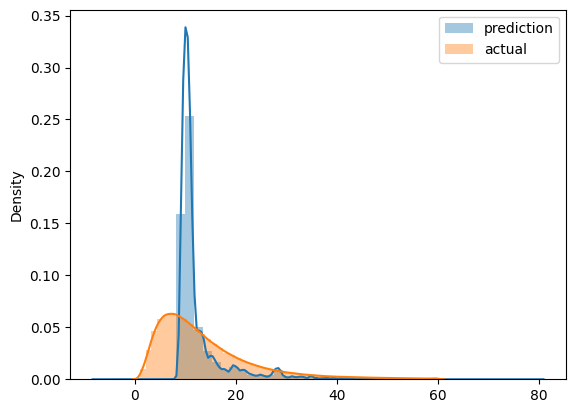

In [99]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()